In [1]:
%load_ext autoreload
%autoreload 2
    
import os, sys
#PWD = os.getenv('PWD')
PWD = '/Users/chris/Documents/lab/emAnalysis/backend/server'

PROJ_MISSING_MSG = """Set an enviroment variable:\n
`DJANGO_PROJECT=your_project_name`\n
or call:\n
`init_django(your_project_name)`
"""

def init_django(project_name=None):
    os.chdir(PWD)
    project_name = project_name or os.environ.get('DJANGO_PROJECT') or None
    if project_name == None:
        raise Exception(PROJ_MISSING_MSG)
    sys.path.insert(0, os.getenv('PWD'))
    os.environ.setdefault('DJANGO_SETTINGS_MODULE', f'{project_name}.settings')
    os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
    import django
    django.setup()

init_django("server")
from django.conf import settings
media_root = settings.MEDIA_ROOT
import numpy as np
import os
from matplotlib import pyplot as plt
import functools
import math
import sims
import copy
import cv2
import os
from pathlib import Path
import numpy as np
from skimage.measure import regionprops
from scipy import spatial
import pickle
from matplotlib.figure import Figure
import pyvips
from core.models import Canvas
from mims.models import MIMSImage, MIMSImageSet
from PIL import Image
from scipy.ndimage import rotate
import pprint
import sims
import SimpleITK as sitk
import tifffile

In [2]:
from mims.services.register import register_images

# canvas_names = ["73_6hrfast_M1", "75_6hrfast_M2", "77_6hrfast_M3", "79_1hr13C_M1",
#                "81_1hr13C_M2_1", "81_1hr13C_M2_2", "83_1hr13C_M3", "85_ONfast_M1",
#                "87_ONfast_M2", "89_ONfast_M3"]
canvas_names = ["79_1hr13C_M1"]
roi_name = "79_mosaic7_1."
for canvas_name in canvas_names:
    canvas = Canvas.objects.get(name=canvas_name)
    mims_images = MIMSImage.objects.filter(canvas=canvas)
    print([m.file.path for m in mims_images if roi_name in m.file.path])
    if roi_name:
        mims_images = [m for m in mims_images if roi_name in m.file.path]
    # Get the counts for each status and print with canvas name
    statuses = list(set([m.status for m in mims_images]))
    status_counts = {status: len([m for m in mims_images if m.status == status]) for status in statuses}
    print(canvas_name)
    print(status_counts)
    registering = [m for m in mims_images]
    
    for mims_image in registering:
        mims_image.refresh_from_db()
        print("registering", mims_image.file.name)
        register_images(mims_image.id)

    
    

['/Users/chris/Documents/lab/emAnalysis/backend/server/media/mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/79_mosaic7_1.im']
79_1hr13C_M1
{'DEWARPED_ALIGNED': 1}
registering mims_image_sets/a1b5db3c-b189-4bb1-8d0c-c4311a2b9b2a/mims_images/79_mosaic7_1.im
mean residual (px): 5034.744935661524
after apply translation 3.6561450958251953
after savez 97.60565185546875
pre unwarp 97.60947179794312
post unwarp 116.7272560596466
done


[[7873, 27824], [18639, 27824], [18639, 38590], [7873, 38590]]


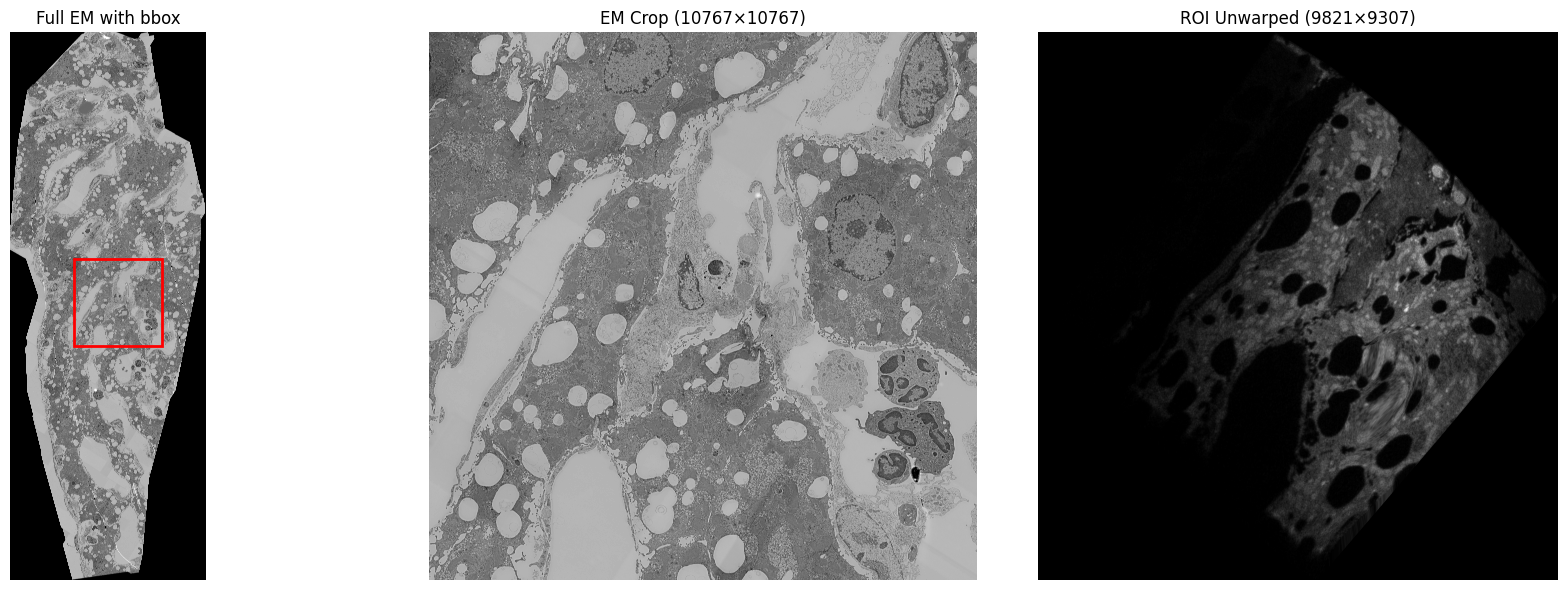

In [4]:
from core.models import Canvas
from mims.models import MimsTiffImage
import tifffile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def inspect_roi_bbox(canvas_name, isotope_name, roi_name):
    # 1) Load EM
    canvas = Canvas.objects.get(name=canvas_name)
    em = tifffile.imread(canvas.images.first().file.path)

    # 2) Load ROI
    roi = MimsTiffImage.objects.get(
        mims_image__canvas=canvas,
        name=isotope_name,
        mims_image__file__icontains=roi_name
    )
    roi_arr = np.array(Image.open(roi.image.path))
    H_roi, W_roi = roi_arr.shape

    # 3) Extract bbox coords (x = column, y = row)
    bbox = np.array(roi.registration_bbox)
    print(roi.registration_bbox)
    xs = bbox[:, 0]
    ys = bbox[:, 1]
    min_x, max_x = int(xs.min()), int(xs.max())
    min_y, max_y = int(ys.min()), int(ys.max())

    # 4) Crop EM
    em_crop = em[min_y:max_y+1, min_x:max_x+1]
    H_crop, W_crop = em_crop.shape

    # 5) Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Full EM + bbox
    axes[0].imshow(em, cmap='gray')
    rect = plt.Rectangle((min_x, min_y),
                         max_x - min_x,
                         max_y - min_y,
                         edgecolor='red', fill=False, linewidth=2)
    axes[0].add_patch(rect)
    axes[0].set_title('Full EM with bbox')
    axes[0].axis('off')

    # EM Crop
    axes[1].imshow(em_crop, cmap='gray')
    axes[1].set_title(f'EM Crop ({H_crop}×{W_crop})')
    axes[1].axis('off')

    # ROI Unwarped
    axes[2].imshow(roi_arr, cmap='gray')
    axes[2].set_title(f'ROI Unwarped ({H_roi}×{W_roi})')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage:
inspect_roi_bbox('79_1hr13C_M1', '32S', '79_mosaic7_1.')